In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
XXSMALL_SIZE = 11
XSMALL_SIZE = 12
SMALL_SIZE = 13
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=XXSMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=XXSMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=XXSMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=XSMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [3]:
with open("hsvp.variant.lengths") as file:
    lines = [line.rstrip() for line in file]

In [4]:
lines[0:10]

['58', '160', '82', '59', '113', '38630', '121', '632', '224', '335']

# Mouse vs fly search

In [5]:
# cd /srv/data/evelina/mouse
# grep ">" dna4.fasta | sed 's/>//g' | sed 's/,//g' | awk '{print "\"" $1 "\"" ":\t\"" $6 " " $7 "\","}' | grep -v Concatenated | sed 's/unplaced genomic/unplaced scaffold/g'
mouse_dname_d = {"NC_000067.7":	"1",
"NT_166280.1":	"1",
"NT_166281.1":	"1",
"NT_166282.1":	"1",
"NT_162750.1":	"1",
"NT_166338.1":	"1",
"NC_000068.8":	"2",
"NC_000069.7":	"3",
"NC_000070.7":	"4",
"NC_000071.7":	"5",
"NT_187056.1":	"5",
"NT_187057.1":	"5",
"NT_187058.1":	"5",
"NT_166438.1":	"5",
"NT_187059.1":	"5",
"NC_000072.7":	"6",
"NC_000073.7":	"7",
"NT_166307.1":	"7",
"NC_000074.7":	"8",
"NC_000075.7":	"9",
"NC_000076.7":	"10",
"NC_000077.7":	"11",
"NC_000078.7":	"12",
"NC_000079.7":	"13",
"NC_000080.7":	"14",
"NC_000081.7":	"15",
"NC_000082.7":	"16",
"NC_000083.7":	"17",
"NC_000084.7":	"18",
"NC_000085.7":	"19",
"NC_000086.8":	"X",
"NT_165789.3":	"X",
"NC_000087.8":	"Y",
"NT_187060.1":	"Y",
"NT_187061.1":	"Y",
"NT_187062.1":	"Y",
"NT_187063.1":	"Y",
"NT_166451.1":	"unplaced scaffold",
"NT_166462.1":	"unplaced scaffold",
"NT_166465.1":	"unplaced scaffold",
"NT_166466.1":	"unplaced scaffold",
"NT_166467.1":	"unplaced scaffold",
"NT_166469.1":	"unplaced scaffold",
"NT_166474.1":	"unplaced scaffold",
"NT_166476.1":	"unplaced scaffold",
"NT_166478.1":	"unplaced scaffold",
"NT_166443.1":	"unplaced scaffold",
"NT_166444.1":	"unplaced scaffold",
"NT_166480.1":	"unplaced scaffold",
"NT_166456.1":	"unplaced scaffold",
"NT_166471.1":	"unplaced scaffold",
"NT_166473.1":	"unplaced scaffold",
"NT_166454.1":	"unplaced scaffold",
"NT_166463.1":	"unplaced scaffold",
"NT_166450.1":	"unplaced scaffold",
"NT_166452.1":	"unplaced scaffold",
"NT_187064.1":	"unplaced scaffold",
"NW_023337853.1":	"unplaced scaffold",}

mouse_dname_d.get("NT_166473.1")

'unplaced scaffold'

In [6]:
def read_stellar_output(filename):
    df = pd.read_csv("dream_stellar_e0.0267_truth.only.gff", sep = "\t", header = None)
    df.drop([1, 2, 6, 7], axis = 1, inplace = True) 
    df.columns = ["dname", "begin", "end", "percid", "acc"]
    df["len"] = np.abs(df["end"] - df["begin"])
    df[['qname','seq2Range', 'evalue', 'cigar', 'mutations']] = df['acc'].str.split(';',expand=True)
    df.drop(["cigar", "mutations", "seq2Range", "acc"], axis = 1, inplace = True) 
    df = pd.merge(df, mouse_dname_d, how="left", on = ["dname"])
    df['evalue'] = df['evalue'].str.replace('eValue=', '')
    df.evalue = df.evalue.astype(float)
    df.head()

In [7]:
def read_count_table(in_dir, filename):
    df = pd.read_csv(in_dir + "/" + filename, sep = "\t", header = None)
    df.columns = ["count", "dname", "qname"]
    df["chr"] = [mouse_dname_d.get(dname) for dname in df["dname"]]
    return df

def gather_counts(df, col):
    counts = []
    names = np.unique(df[col])
    for name in names:
        counts.append(np.sum(df[df[col] == name]["count"]))

    d = {'names': names, 'counts': counts} 
    return pd.DataFrame(d)

def get_count_df(in_dir):
    fn = read_count_table(in_dir, "fn_count_table.tsv")
    fp = read_count_table(in_dir, "fp_count_table.tsv")
    fp_counts = gather_counts(fp, "chr")
    fn_counts = gather_counts(fn, "chr")
    df = fp_counts.set_index('names').join(fn_counts.set_index('names'), lsuffix='_fp', rsuffix='_fn', on='names')
    df = df.fillna(0)
    df = df.astype({"counts_fp":int, "counts_fn":int})
    return df

In [8]:
def set_ax_plot(ax, df, tool, typename):
    chromosomes = [str(x) for x in range(1, 20)]
    chromosomes.append("X")
    chromosomes.append("Y")

    x = np.arange(len(chromosomes))  # the label locations
    width = 0.33  # the width of the bars
    
    multiplier = 1

    counts = df["counts_fn"].values
    offset = width * multiplier
    rects = ax.bar(x + offset, counts, width, label="missed eps (" + str(sum(df["counts_fn"].values)) + ")" , color = CB_color_cycle[7])
    #ax.bar_label(rects, padding=3)
    multiplier += 1

    counts = df["counts_fp"].values
    offset = width * multiplier
    rects = ax.bar(x + offset, counts, width, label=tool + " l<50 e>2 (" + str(sum(df["counts_fp"].values)) + ")", color = CB_color_cycle[6])
    #ax.bar_label(rects, padding=3)
    multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(typename)
    ax.set_xticks(x + width, [str(x) for x in chromosomes])
    ax.set_xlabel("Mouse chr")
    ax.set_ylabel("Matches in fly")
    ax.legend(loc='upper left', ncols=1)

# BLAST

In [9]:
in_dir="k24_blast_vs_stellar_l50_e2"
df = get_count_df(in_dir)
df.head()

,counts_fp,counts_fn
names,,
1,3882,78
10,3706,3
11,2615,59
12,2263,11
13,1903,96


In [10]:
np.sum(df["counts_fp"])

56789

In [11]:
56789 - 21347

35442

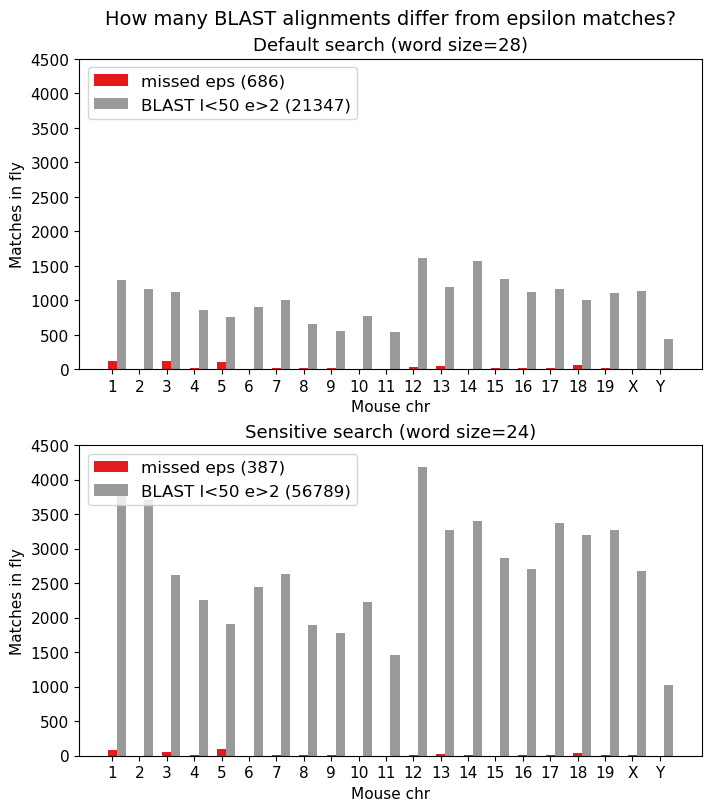

In [12]:
fig, (ax1, ax2) = plt.subplots(2, layout='constrained')
fig.set_figheight(8)
fig.set_figwidth(7)
fig.suptitle('How many BLAST alignments differ from epsilon matches?', fontsize=MEDIUM_SIZE, x = 0.55)

in_dir="k28_blast_vs_stellar_l50_e2"
df = get_count_df(in_dir)
set_ax_plot(ax1, df, "BLAST", "Default search (word size=28)")
ax1.set_ylim(0, 4500)

in_dir="k24_blast_vs_stellar_l50_e2"
df = get_count_df(in_dir)
set_ax_plot(ax2, df, "BLAST", "Sensitive search (word size=24)")
ax2.set_ylim(0, 4500)

plt.savefig('blast_mouse_search.svg', dpi = 500)
plt.show()

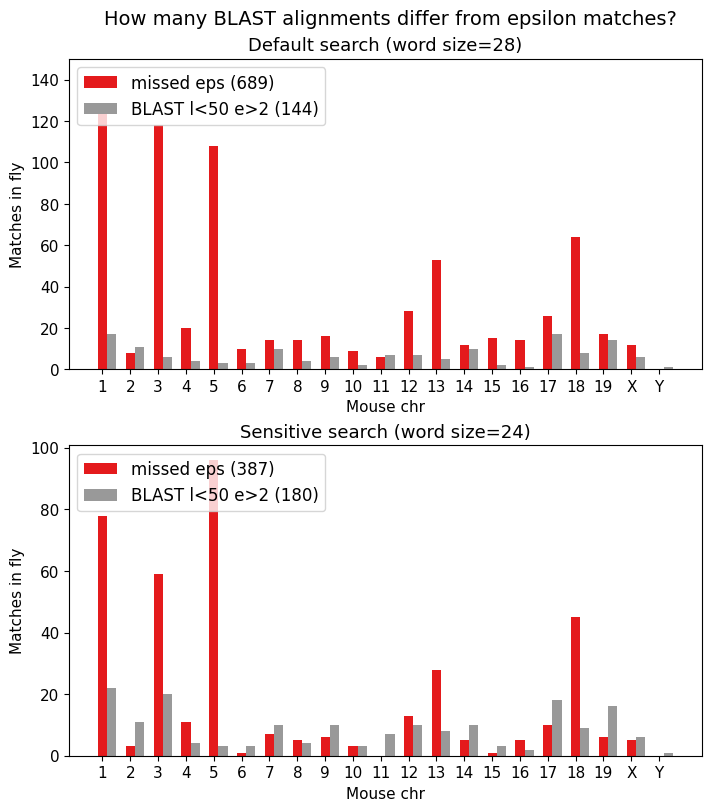

In [17]:
fig, (ax1, ax2) = plt.subplots(2, layout='constrained')
fig.set_figheight(8)
fig.set_figwidth(7)
fig.suptitle('How many BLAST alignments differ from epsilon matches?', fontsize=MEDIUM_SIZE, x = 0.55)

in_dir="e1e-5_k28_blast_vs_stellar_l50_e2"
df = get_count_df(in_dir)
set_ax_plot(ax1, df, "BLAST", "Default search (word size=28)")
ax1.set_ylim(0, 150)

in_dir="e1e-5_k24_blast_vs_stellar_l50_e2"
df = get_count_df(in_dir)
set_ax_plot(ax2, df, "BLAST", "Sensitive search (word size=24)")
ax1.set_ylim(0, 150)

plt.savefig('e1e-5_blast_mouse_search.svg', dpi = 500)
plt.show()

# LAST

In [18]:
in_dir="m100_last_vs_stellar_l50_e2"
df = get_count_df(in_dir)
df.head()

,counts_fp,counts_fn
names,,
1,39,0
10,44,0
11,43,0
12,20,0
13,35,0


In [19]:
np.sum(df["counts_fp"])

880

In [20]:
766 - 663

103

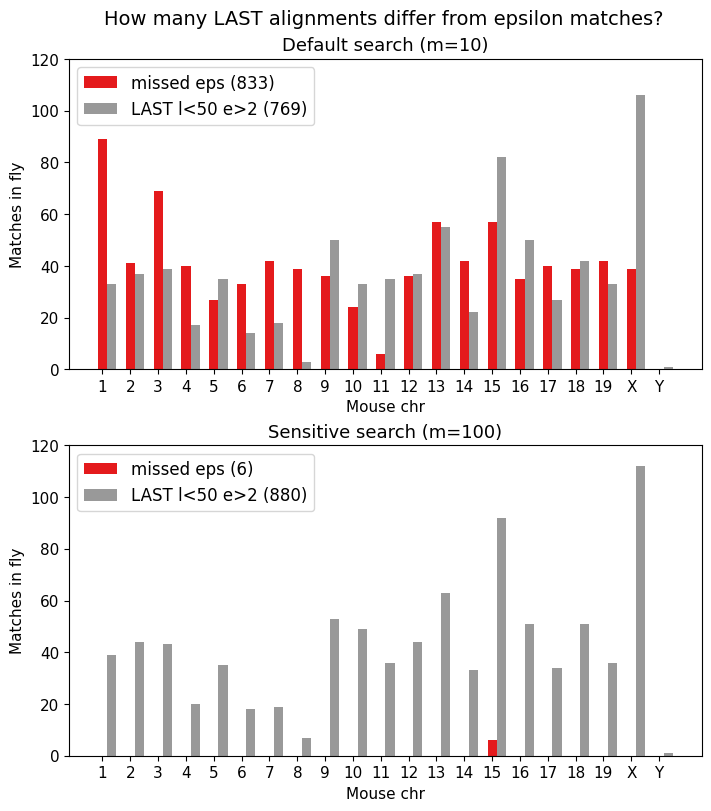

In [21]:
tool = "LAST"    
fig, (ax1, ax2) = plt.subplots(2, layout='constrained')
fig.set_figheight(8)
fig.set_figwidth(7)
fig.suptitle('How many LAST alignments differ from epsilon matches?', fontsize=MEDIUM_SIZE, x = 0.54)

in_dir="m10_last_vs_stellar_l50_e2"
df = get_count_df(in_dir)
set_ax_plot(ax1, df, tool, "Default search (m=10)")
ax1.set_ylim(0, 120)

in_dir="m100_last_vs_stellar_l50_e2"
df = get_count_df(in_dir)
set_ax_plot(ax2, df, tool, "Sensitive search (m=100)")
ax2.set_ylim(0, 120)

plt.savefig('last_mouse_search.svg', dpi = 500)
plt.show()

# LASTZ

In [22]:
in_dir="s3_lastz_vs_stellar_l50_e2"
df = get_count_df(in_dir)
df.head()

,counts_fp,counts_fn
names,,
1,40,5
10,47,0
11,27,6
12,13,1
13,21,0


In [23]:
np.sum(df["counts_fp"])

666

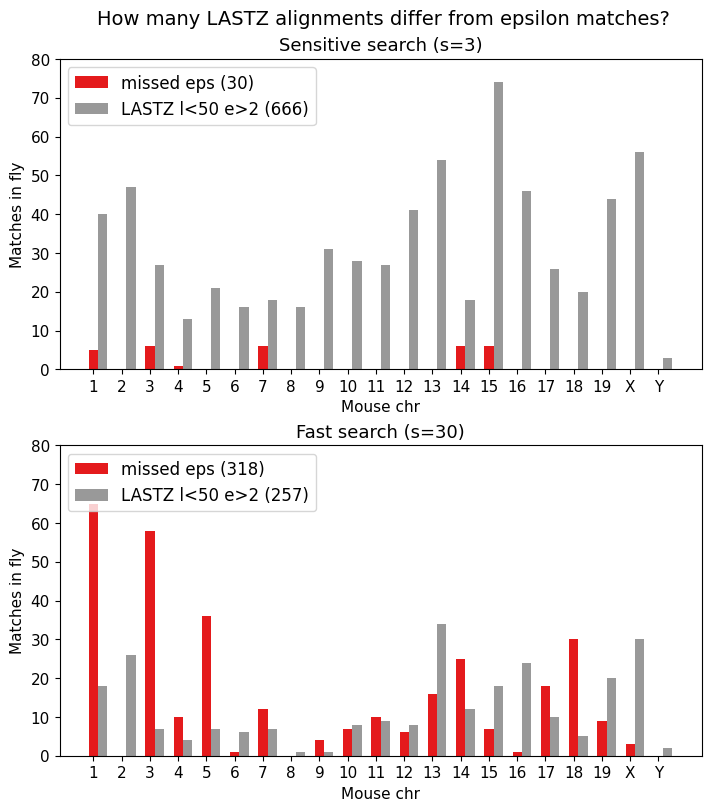

In [24]:
tool = "LASTZ"
fig, (ax1, ax2) = plt.subplots(2, layout='constrained')
fig.set_figheight(8)
fig.set_figwidth(7)
fig.suptitle('How many LASTZ alignments differ from epsilon matches?', fontsize=MEDIUM_SIZE, x = 0.54)

in_dir="s3_lastz_vs_stellar_l50_e2"
df = get_count_df(in_dir)
set_ax_plot(ax1, df, tool, "Sensitive search (s=3)")
ax1.set_ylim(0, 80)

in_dir="s30_lastz_vs_stellar_l50_e2"
df = get_count_df(in_dir)
set_ax_plot(ax2, df, tool, "Fast search (s=30)")
ax2.set_ylim(0, 80)

plt.savefig('lastz_mouse_search.svg', dpi = 250)
plt.show()

# Human vs mouse search